<a href="https://colab.research.google.com/github/jermwatt/morphi_lab/blob/collab_demos/scratch_notebooks%20/2_video_pipeline_unoptimized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.  Setup

In [3]:
# install reqiuredlibraries 
!pip install "ultralytics==8.0.111" "transformers==4.29.2" "timm==0.9.2" "diffusers==0.16.1" "safetensors==0.3.1"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
# pull yolo model to this macine
!curl -sSL -o /content/yolov8s-seg.pt https://github.com/ultralytics/assets/releases/download/v0.0.0/yolov8s-seg.pt

# 1.  Segmenter

## 1.0. Functions

In [10]:
from ultralytics import YOLO
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
import os
parent_dir = os.getcwd()


class Segmenter:
    def __init__(self, conf=0.5):
        self.conf = conf
        self.model = YOLO(parent_dir + '/YOLOv8s-seg.pt')
        self.img = None
        self.img_height = None
        self.img_width = None
        self.xmin = None
        self.ymin = None
        self.xmax = None
        self.ymax = None
        self.seg = None
        self.segmentation_result = None
        self.detection_window_path = dir_path + '/temp/temp.png'

    def reset(self):
        self.img = None
        self.xmin = None
        self.ymin = None
        self.xmax = None
        self.ymax = None
        self.seg = None
        self.width = None
        self.height = None
        self.segmentation_result = None

    def read_img_path(self, img_path):
        self.reset()
        self.img = cv2.imread(img_path)
        h, w, _ = self.img.shape
        self.height = h
        self.width = w

    def read_img(self, img):
        self.reset()
        self.img = img
        h, w, _ = self.img.shape
        self.height = h
        self.width = w

    def segment(self):
        self.segmentation_result = self.model.predict(source=self.img,
                                                      classes=[39, 41, 67],
                                                      conf=self.conf,
                                                      show_labels=False,
                                                      boxes=False,
                                                      verbose=False,
                                                      half=True,
                                                      max_det=1)

        # class names
        self.class_names = self.model.names

        # random colors for plotting
        # self.colors = [[random.randint(0, 255) for _ in range(3)] for _ in self.class_names]
        self.colors = [[100,0,100] for _ in self.class_names]

        # extract segmentation result
        h, w, _ = self.img.shape
        boxes = self.segmentation_result[0].boxes
        masks = self.segmentation_result[0].masks

        if masks is not None:
            masks = masks.data.cpu()
            for seg, box in zip(masks.data.cpu().numpy(), boxes):
                seg = cv2.resize(seg, (w, h)).astype(np.uint8)

                self.xmin = int(box.data[0][0])
                self.ymin = int(box.data[0][1])
                self.xmax = int(box.data[0][2])
                self.ymax = int(box.data[0][3])
                self.seg = seg

                self.detection_window = self.img[self.ymin:self.ymax,
                                                 self.xmin:self.xmax]

                break

    def save_segment(self):
        cv2.imwrite(self.detection_window_path, self.detection_window)

    @staticmethod
    def overlay(image, mask, color, alpha, resize=None):
        colored_mask = np.expand_dims(mask, 0).repeat(3, axis=0)
        colored_mask = np.moveaxis(colored_mask, 0, -1)
        masked = np.ma.MaskedArray(image, mask=colored_mask, fill_value=color)
        image_overlay = masked.filled()

        if resize is not None:
            image = cv2.resize(image.transpose(1, 2, 0), resize)
            image_overlay = cv2.resize(image_overlay.transpose(1, 2, 0), resize)

        image_combined = cv2.addWeighted(image, 1 - alpha, image_overlay, alpha, 0)

        return image_combined

    @staticmethod
    def plot_one_box(x, img, color=None, label=None, line_thickness=3):
        # Plots one bounding box on image img
        tl = line_thickness or round(0.002 * (img.shape[0] + img.shape[1]) / 2) + 1  # line/font thickness
        color = color or [random.randint(0, 255) for _ in range(3)]
        c1, c2 = (int(x[0]), int(x[1])), (int(x[2]), int(x[3]))
        cv2.rectangle(img, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
        if label:
            tf = max(tl - 1, 1)  # font thickness
            t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
            c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
            cv2.rectangle(img, c1, c2, color, -1, cv2.LINE_AA)  # filled
            cv2.putText(img, label, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)

    def project_segmentations(self, show_overlay=True, show_boxes=False, show_result=False):
        # unpack segmentation results
        boxes = self.segmentation_result[0].boxes
        masks = self.segmentation_result[0].masks

        # loop over masks and plot
        if masks is not None:
            masks = masks.data.cpu()
            for seg, box in zip(masks.data.cpu().numpy(), boxes):
                seg = cv2.resize(seg, (self.width, self.height)).astype(np.uint8)

                if show_overlay:
                    self.img = self.overlay(self.img, seg, self.colors[int(box.cls)], 0.4)

                xmin = int(box.data[0][0])
                ymin = int(box.data[0][1])
                xmax = int(box.data[0][2])
                ymax = int(box.data[0][3])

                if show_boxes:
                    self.plot_one_box([xmin, ymin, xmax, ymax],
                                      self.img,
                                      self.colors[int(box.cls)],
                                      f'{self.class_names[int(box.cls)]} {float(box.conf):.3}')

    def show_result(self):
        # image_rgb = cv2.imshow('img', img)
        image_rgb = cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB)

        plt.imshow(image_rgb)
        plt.axis('off')  # optional: disable the axis
        plt.show()

## 1.1.  Image test

In [20]:
# pull image
!curl -sSL -o /content/test_img.png https://github.com/jermwatt/morphi_lab/blob/collab_demos/test_data/test_input/test_img.png?raw=true 

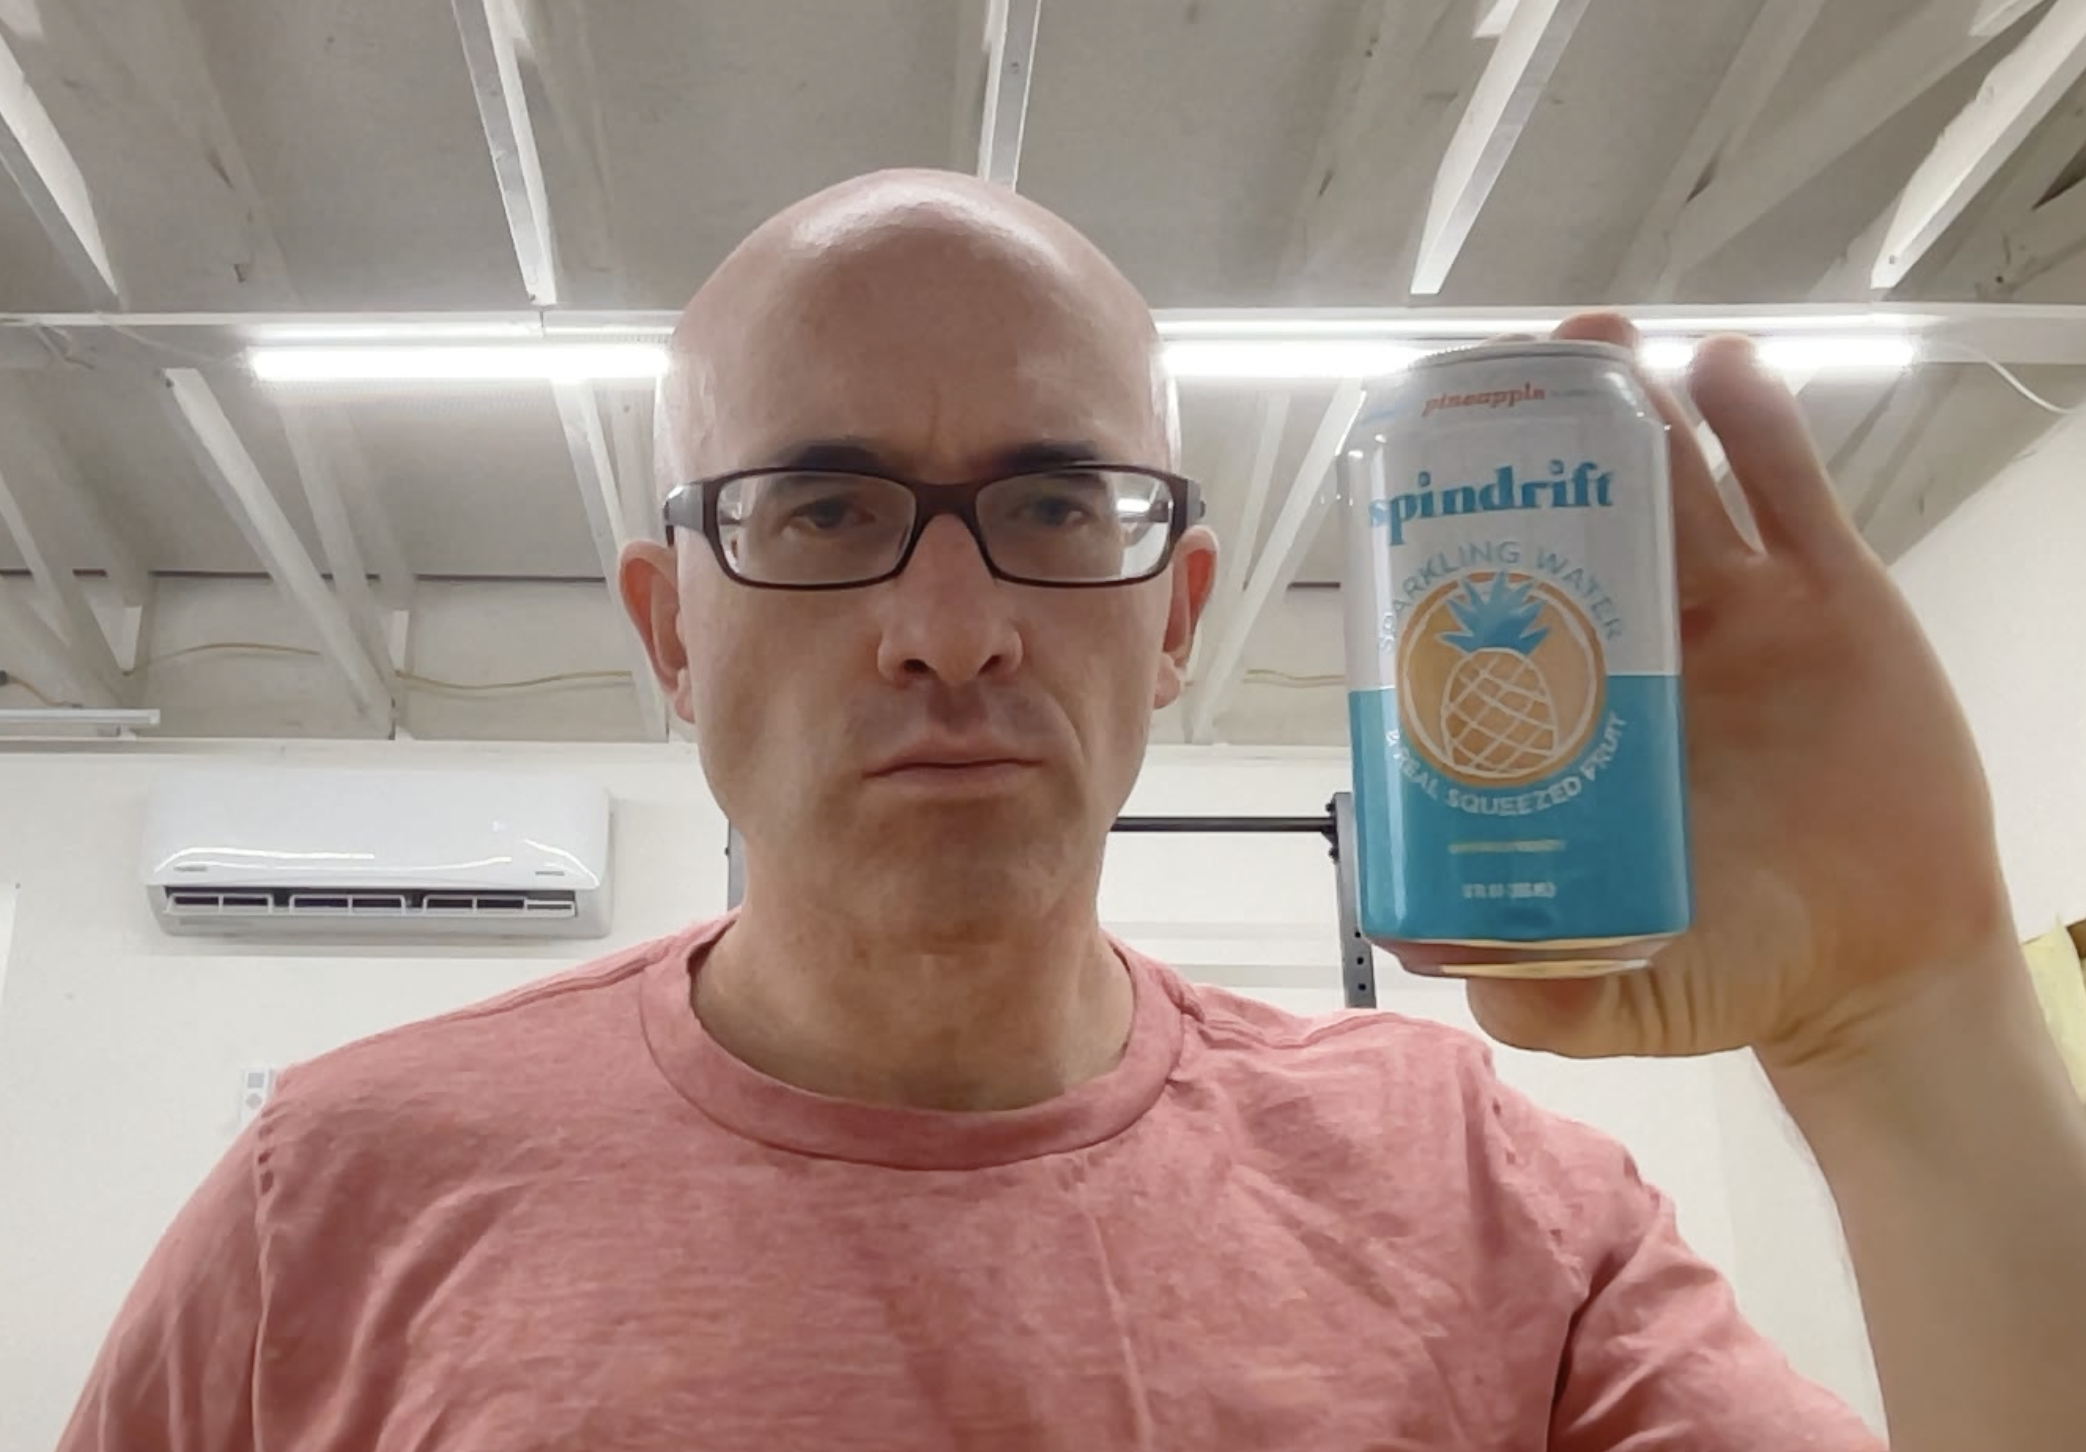

In [25]:
from PIL import Image

# path to image 
img_path = "/content/test_img.png"

# load in image
img = cv2.imread(img_path)

# show img
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = Image.fromarray(img)
img = img.convert('RGB')
img

DisabledFunctionError: ignored